# chex

In [ ]:

from dataclasses import dataclass
import logging
import os
from typing import Optional
import einops
from torch import Tensor
from torch import nn
import torch
import torch.nn.functional as F
from chexzero.model import VisualTransformer
from model.components.mlp import MLP
from model.img_encoder import ImageEncoderOutput
import torch
from transformers import AutoModel, AutoImageProcessor


from util.model_utils import BaseModel, BaseModelConfig, MainModelConfig
import chexzero.clip

log = logging.getLogger(__name__)

@dataclass
class ChexzeroImageEncoderConfig(BaseModelConfig):
    model_path: str = os.path.join(os.environ.get('MODELS_DIR'),"best_64_5e-05_original_22000_0.864.pt")
    frozen_backbone: bool = False
    # freeze over full training, i.e. never unfreeze
    freeze_backbone_layers: Optional[int] = None

    add_cls_features: bool = False
    use_pretrained_projection: bool = True
    # 0 = no additionl projection, 1 = linear, 2 = one hidden layer
    additional_projection_layers: int = 0
    projection_bn: bool = False
    normalize_projected: bool = False

class ChexzeroImageEncoder(BaseModel):
    CONFIG_CLS = ChexzeroImageEncoderConfig
    MODIFYABLE_CONFIGS = ('frozen_backbone', )

    def __init__(self, config: ChexzeroImageEncoderConfig, main_config: MainModelConfig):
        super().__init__(config)
        self.config: ChexzeroImageEncoderConfig

        # model, _ = chexzero.clip.load("ViT-B/32", device='cpu', jit=False)
        # model.load_state_dict(torch.load('/vol/biomedic3/mq21/master/lw1824/chex/chex/models/third_party/chexzero/CheXzero_Models/best_64_5e-05_original_22000_0.864.pt', map_location='cpu'))
        
        # 定义本地模型目录路径
        local_repo_path = "/vol/biomedic3/mq21/master/lw1824/chex/chex/cache/rad-dino"

        # 从本地路径加载模型
        model = AutoModel.from_pretrained(local_repo_path)        


In [ ]:
%cd /vol/bitbucket/lw1824/chex/chex/src
from dataclasses import dataclass
import logging
import os
from typing import Optional
import einops
from torch import Tensor
from torch import nn
import torch
import torch.nn.functional as F
from chexzero.model import VisualTransformer
from model.components.mlp import MLP
from model.img_encoder import ImageEncoderOutput
import torch
from transformers import AutoModel, AutoImageProcessor
import chexzero.clip

: 

In [28]:
collapse
model_vit, _ = chexzero.clip.load("ViT-B/32", device='cpu', jit=False)
model_vit.load_state_dict(torch.load('/vol/bitbucket/lw1824/chex/chex/models/third_party/chexzero/CheXzero_Models/best_64_5e-05_original_22000_0.864.pt', map_location='cpu'))
model_vit=model_vit.visual

# chex andd Rad-DINO

In [4]:
H=W=int(inputs.pixel_values.shape[2]/14)
N=inputs.pixel_values.shape[0]
print(H,W)
x = model.embeddings.patch_embeddings(inputs.pixel_values[:,:,:512,:512])  # shape = [*, width, grid, grid]
print(x.shape)
%%collapse
# Add CLS token
cls_token = model.embeddings.cls_token.expand(N, -1, -1)
print(cls_token.shape)
x = torch.cat([cls_token, x], dim=1)
print(x.shape)

# Add position embeddings
pos_emb = model.embeddings.position_embeddings
pos_emb=pos_emb.squeeze(0)
x = x + pos_emb
print(pos_emb.shape)
print(x.shape)
# Pass through transformer layers
for layer in model.encoder.layer:
    x = layer(x)[0]


# print(x.shape)
# Extract features
cls_features = model.layernorm(x[:, 0, :])
if True:
    patch_features = model.layernorm(x[:, 1:, :] + x[:, 0, :].unsqueeze(1))
else:
    # (N x HW x d)
    patch_features = model.layernorm(x[:, 1:, :])

pos_embeddings = pos_emb[1:]

# Reshape patch features back to spatial dimensions
patch_features = einops.rearrange(patch_features, 'n (h w) d -> n h w d', h=H, w=W)
pos_embeddings = einops.repeat(pos_embeddings, '(h w) d -> n h w d', h=H, w=W, n=N)
print(patch_features.shape)
print(pos_embeddings.shape)

# Project features if needed
# if hasattr(self, 'patch_projection'):
if True:
    projected_patch_features = self.patch_projection(patch_features)
    cls_features = self.patch_projection(cls_features.unsqueeze(1)).squeeze(1)
    pos_embeddings = self.patch_projection(pos_embeddings)

    # if self.config.normalize_projected:
    if True:
        projected_patch_features = F.normalize(projected_patch_features, dim=-1)
        cls_features = F.normalize(cls_features, dim=-1)
else:
    projected_patch_features = patch_features

# Create position embeddings for output# print(patch_features.shape)
# return ImageEncoderOutput(
#     patch_features=projected_patch_features,
#     pos_embeddings=pos_embeddings,
#     global_features=cls_features)

NameError: name 'inputs' is not defined

input: 原来：preproc 32\*7 现在：processer 32*16 
## 替换生成产物，借助shape对齐

In [88]:
x = model_vit.conv1(inputs.pixel_values[:,:,:224,:224])  # shape = [*, width, grid, grid]
N, _, H, W = x.shape
x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

print(x.shape)
x = torch.cat([model_vit.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, dim] #给一个分类token
pos_emb = model_vit.positional_embedding.to(x.dtype)  # shape = [grid ** 2 + 1, dim]
print(model_vit.positional_embedding.shape,x.shape)
print(pos_emb.shape,x.shape)
x = x + pos_emb
x = model_vit.ln_pre(x)

x = x.permute(1, 0, 2)  # NLD -> LND
x = model_vit.transformer(x)
x = x.permute(1, 0, 2)  # LND -> NLD



# (N x d)
if True:
    patch_features = model_vit.ln_post(x[:, 1:, :] + x[:, 0, :].unsqueeze(1))
else:
    # (N x HW x d)
    patch_features = model_vit.ln_post(x[:, 1:, :])
print(patch_features.shape)
if True:
    patch_features = patch_features @ model_vit.proj


# (N, H, W, d_backbone)
patch_features = einops.rearrange(patch_features, 'n (h w) d -> n h w d', h=H, w=W)
print(patch_features.shape)
projected_patch_features = self.patch_projection(patch_features)
if True:
    pos_embeddings = self.patch_projection(pos_embeddings)
if True:
    projected_patch_features = F.normalize(projected_patch_features, dim=-1)
projected_patch_features
# return ImageEncoderOutput(
#     patch_features=projected_patch_features,
#     pos_embeddings=pos_embeddings,
#     global_features=cls_features)

torch.Size([1, 49, 768])
torch.Size([50, 768]) torch.Size([1, 50, 768])
torch.Size([50, 768]) torch.Size([1, 50, 768])
torch.Size([1, 49, 768])
torch.Size([1, 7, 7, 512])


NameError: name 'self' is not defined

In [ ]:
x = self.backbone.conv1(x)  # shape = [*, width, grid, grid]
N, _, H, W = x.shape
x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
x = torch.cat([self.backbone.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
pos_emb = self.backbone.positional_embedding.to(x.dtype)  # shape = [grid ** 2 + 1, width]
x = x + pos_emb
x = self.backbone.ln_pre(x)

x = x.permute(1, 0, 2)  # NLD -> LND
x = self.backbone.transformer(x)
x = x.permute(1, 0, 2)  # LND -> NLD

# (N x d)
cls_features = self.backbone.ln_post(x[:, 0, :])
if self.config.add_cls_features:
    patch_features = self.backbone.ln_post(x[:, 1:, :] + x[:, 0, :].unsqueeze(1))
else:
    # (N x HW x d)
    patch_features = self.backbone.ln_post(x[:, 1:, :])

# if self.config.use_pretrained_projection:
#     cls_features = cls_features @ self.backbone.proj
#     patch_features = patch_features @ self.backbone.proj
#     pos_embeddings = pos_emb[1:] @ self.backbone.proj
# else:
pos_embeddings = pos_emb[1:]

# (N, H, W, d_backbone)
patch_features = einops.rearrange(patch_features, 'n (h w) d -> n h w d', h=H, w=W)
# (N, H, W, d_backbone) -> (N, H, W, d)
pos_embeddings = einops.repeat(pos_embeddings, '(h w) d -> n h w d', h=H, w=W, n=N)
    
# (N x H x W x d)
projected_patch_features = self.patch_projection(patch_features)
cls_features = self.patch_projection(cls_features.unsqueeze(1)).squeeze(1)
if True:
    pos_embeddings = self.patch_projection(pos_embeddings)

if True:
    projected_patch_features = F.normalize(projected_patch_features, dim=-1)
    cls_features = F.normalize(cls_features, dim=-1)
projected_patch_features
# return ImageEncoderOutput(
#     patch_features=projected_patch_features,
#     pos_embeddings=pos_embeddings,
#     global_features=cls_features)

# Rad-DINO input

### load image

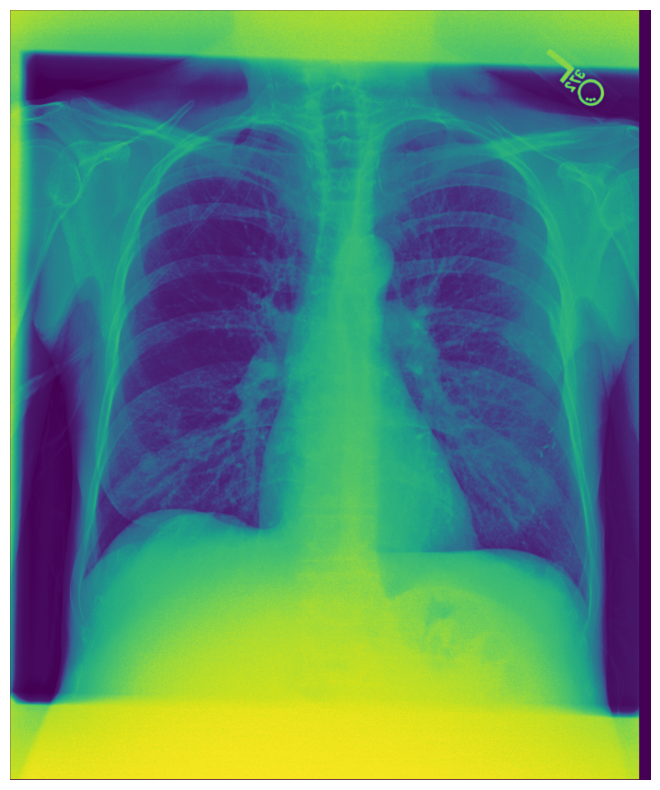

/tmp/ipykernel_2093572/1058626488.py:53: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1058626488.py:53: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/vol/bitbucket/lw1824/anaconda3/envs/chex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/vol/bitbucket/lw1824/anaconda3/envs/chex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


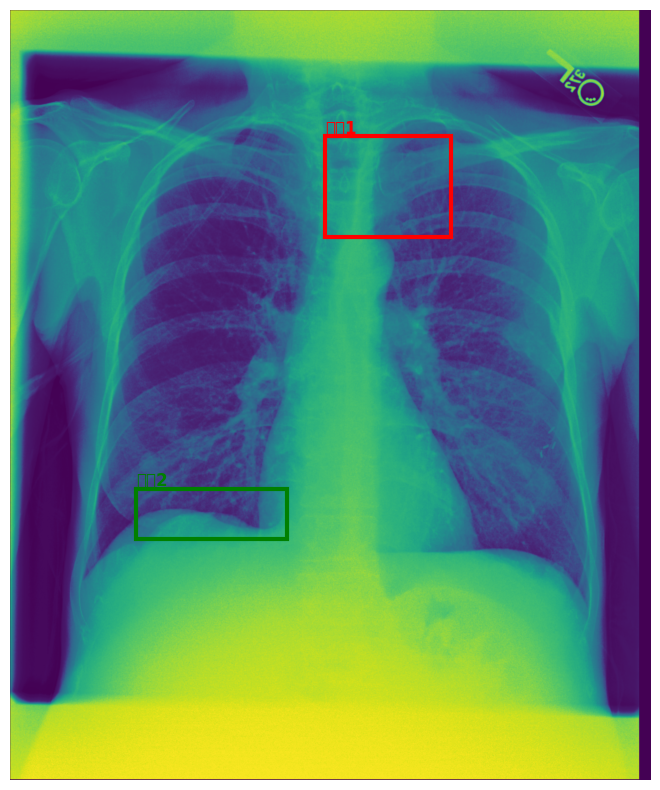

In [1]:
from PIL import Image

# Read the image file
image_path = "/vol/bitbucket/lw1824/chex/chex/dataset/MIMIC-CXR/mimic-cxr-jpg_2-0-0/files/p10/p10000032/s53189527/2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.jpg"
image = Image.open(image_path)
# 使用matplotlib显示图像，而不是使用PIL的show()方法
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

# %% cell 22.5 code

# 在图像上创建两个框
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# 创建一个新的图形
plt.figure(figsize=(10, 8))

# 显示图像
plt.imshow(image)
plt.axis('off')

# 创建两个矩形框

# 注意：matplotlib的坐标系原点在左上角
ax = plt.gca()

# 定义矩形框参数 (中心点x, 中心点y, 宽度, 高度)
# 第一个框 - 左上区域
xc1, yc1, w1, h1 = 1500, 700, 500, 400
# 第二个框 - 右下区域
xc2, yc2, w2, h2 = 800, 2000, 600, 200

# 将中心点坐标转换为左上角坐标
x1, y1 = xc1 - w1/2, yc1 - h1/2
x2, y2 = xc2 - w2/2, yc2 - h2/2

# 创建矩形
rect1 = patches.Rectangle((x1, y1), w1, h1, linewidth=3, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((x2, y2), w2, h2, linewidth=3, edgecolor='g', facecolor='none')

# 将矩形添加到图像上
ax.add_patch(rect1)
ax.add_patch(rect2)

# 添加标签
plt.text(x1, y1-10, '区域1', color='r', fontsize=12, weight='bold')
plt.text(x2, y2-10, '区域2', color='g', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


### load raddino model

In [2]:
import requests
from PIL import Image

def download_sample_image() -> Image.Image:
    """Download chest X-ray with CC license."""
    base_url = "https://upload.wikimedia.org/wikipedia/commons"
    image_url = f"{base_url}/2/20/Chest_X-ray_in_influenza_and_Haemophilus_influenzae.jpg"
    headers = {"User-Agent": "RAD-DINO"}
    response = requests.get(image_url, headers=headers, stream=True)
    return Image.open(response.raw)
import torch
from transformers import AutoModel
from transformers import AutoImageProcessor
# Download the model
repo = "microsoft/rad-dino"
model = AutoModel.from_pretrained(repo)
# The processor takes a PIL image, performs resizing, center-cropping, and
# intensity normalization using stats from MIMIC-CXR, and returns a
# dictionary with a PyTorch tensor ready for the encoder
processor = AutoImageProcessor.from_pretrained(repo)

# Download and preprocess a chest X-ray

inputs = processor(images=image, return_tensors="pt")
# Encode the image!
with torch.inference_mode():
    outputs = model(**inputs)
# Look at the CLS embeddings
cls_embeddings = outputs.pooler_output
cls_embeddings.shape  # (batch_size, num_channels)


/vol/bitbucket/lw1824/anaconda3/envs/chex/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([1, 768])

### show inputs (output of processor)

/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/3638894105.py:27: UserWarning: Glyph 22270 (\N{CJK UN

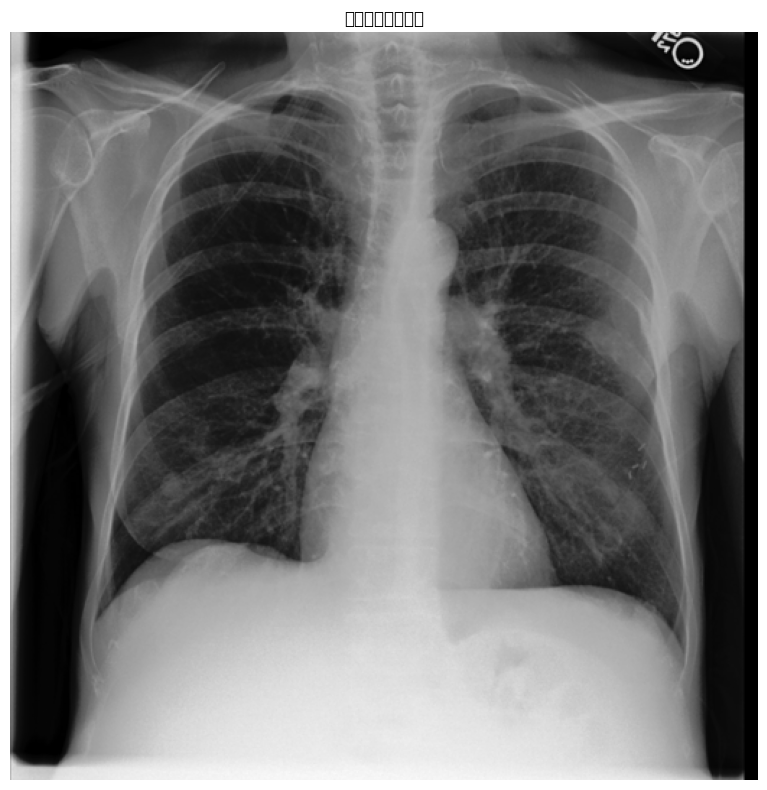

处理后的图像形状: torch.Size([3, 518, 518])


In [4]:
#input to image
# 将模型输入转换回图像并显示
import matplotlib.pyplot as plt
import torch
import numpy as np

# 获取输入张量
pixel_values = inputs.pixel_values[0]  # 形状应为 [C, H, W]

# 将张量从 [C, H, W] 转换为 [H, W, C] 用于显示
img = pixel_values.permute(1, 2, 0).cpu().numpy()

# 反归一化图像 (如果需要)
# 使用处理器中的均值和标准差
mean = torch.tensor(processor.image_mean).reshape(1, 1, 3).numpy()
std = torch.tensor(processor.image_std).reshape(1, 1, 3).numpy()
img = img * std + mean

# 确保像素值在合理范围内
img = np.clip(img, 0, 1)

# 显示图像
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title("处理后的输入图像")
plt.axis('off')
plt.tight_layout()
plt.show()

# 打印图像形状
print(f"处理后的图像形状: {pixel_values.shape}")


### test input (output of processor)

In [8]:
inputs.pixel_values.shape

torch.Size([1, 3, 518, 518])

In [10]:


x=inputs.pixel_values
x=model.embeddings.patch_embeddings(x)
x=x.reshape(1,768,-1)
x=x.permute(0,2,1)
cls=model.embeddings.cls_token.expand(1, -1, -1)
# Add CLS token

print(cls.shape)
x = torch.cat([cls, x], dim=1)
pos_emb=model.embeddings.position_embeddings.squeeze(0)
print(pos_emb.shape)
x = x + pos_emb
for layer in model.encoder.layer:
    print(layer(x))
    x = layer(x)


torch.Size([1, 1, 768])
torch.Size([1370, 768])
(tensor([[[ 0.0115, -0.1472, -0.5816,  ...,  0.0564, -0.1666,  0.0524],
         [-0.1149, -0.1297, -0.3425,  ...,  0.0418, -0.1396,  0.1231],
         [ 0.0538,  0.0491, -0.2180,  ...,  0.0498,  0.0450, -0.4638],
         ...,
         [ 0.0957,  0.2723, -0.3485,  ...,  0.1254, -0.1499,  0.3100],
         [ 0.0437, -0.1865, -0.0770,  ...,  0.0706, -0.5121,  0.2857],
         [-0.0238,  0.1477, -0.1114,  ...,  0.0422, -0.0964,  0.0704]]],
       grad_fn=<AddBackward0>),)


TypeError: layer_norm(): argument 'input' (position 1) must be Tensor, not tuple

In [13]:
print(type(x))
print(x[0])
x

<class 'tuple'>
tensor([[[ 0.0115, -0.1472, -0.5816,  ...,  0.0564, -0.1666,  0.0524],
         [-0.1149, -0.1297, -0.3425,  ...,  0.0418, -0.1396,  0.1231],
         [ 0.0538,  0.0491, -0.2180,  ...,  0.0498,  0.0450, -0.4638],
         ...,
         [ 0.0957,  0.2723, -0.3485,  ...,  0.1254, -0.1499,  0.3100],
         [ 0.0437, -0.1865, -0.0770,  ...,  0.0706, -0.5121,  0.2857],
         [-0.0238,  0.1477, -0.1114,  ...,  0.0422, -0.0964,  0.0704]]],
       grad_fn=<AddBackward0>)


(tensor([[[ 0.0115, -0.1472, -0.5816,  ...,  0.0564, -0.1666,  0.0524],
          [-0.1149, -0.1297, -0.3425,  ...,  0.0418, -0.1396,  0.1231],
          [ 0.0538,  0.0491, -0.2180,  ...,  0.0498,  0.0450, -0.4638],
          ...,
          [ 0.0957,  0.2723, -0.3485,  ...,  0.1254, -0.1499,  0.3100],
          [ 0.0437, -0.1865, -0.0770,  ...,  0.0706, -0.5121,  0.2857],
          [-0.0238,  0.1477, -0.1114,  ...,  0.0422, -0.0964,  0.0704]]],
        grad_fn=<AddBackward0>),)

In [16]:
image.size

(2544, 3056)

(2544, 3056)
(2544, 3056)
[[0.2716195  0.61734653 0.22798742 0.56568665]
 [0.67904872 0.66244098 0.30778301 0.35744977]]


/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2093572/1329775782.py:184: UserWarning: Glyph 30028 (\N

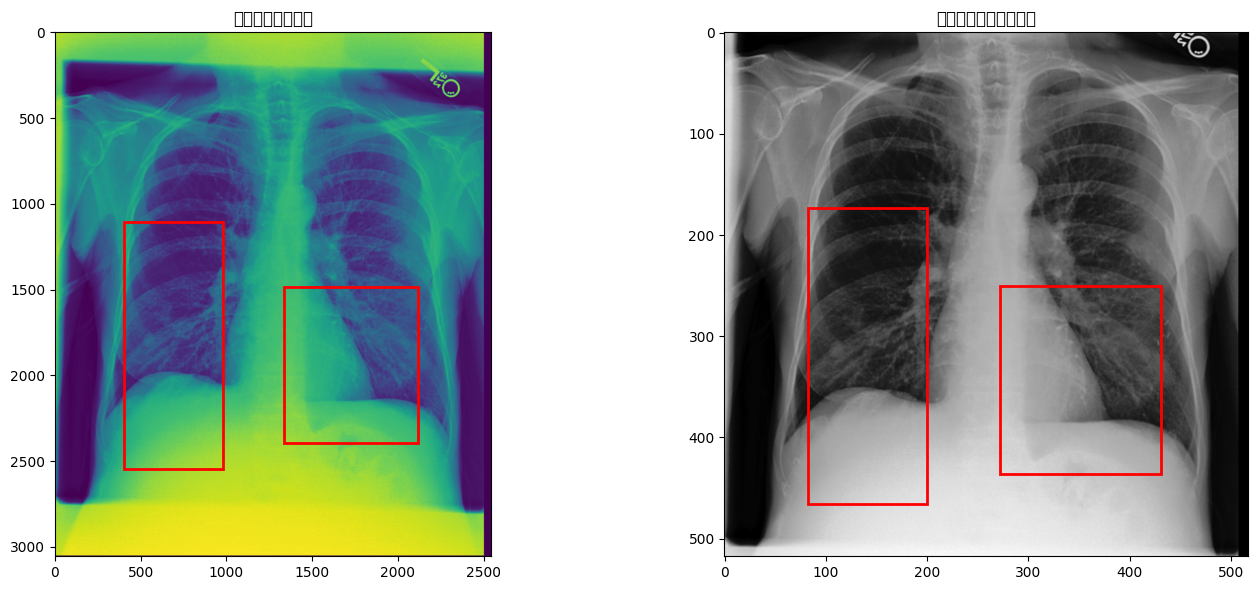

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from PIL import Image

def calculate_resize_scale(original_size, target_size=518):
    # 获取原始宽高
    orig_w, orig_h = original_size
    # 计算最短边的缩放比例
    scale = target_size / min(orig_w, orig_h)
    return scale

def calculate_crop_offset(resized_size, crop_size=518):
    resized_w, resized_h = resized_size
    # 计算裁剪的偏移量
    offset_x = max(0, (resized_w - crop_size) // 2)
    offset_y = max(0, (resized_h - crop_size) // 2)
    return offset_x, offset_y

def transform_box(original_box, original_image_size, target_size=518):
    """
    original_box: [cx, cy, w, h] 格式的边界框，中心点坐标和宽高
    original_image_size: (width, height)
    target_size: 目标尺寸(518)
    """
    print(original_image_size)
    orig_w, orig_h = original_image_size
    
    # 检查输入是否为张量，并提取值
    if isinstance(original_box, torch.Tensor):
        if len(original_box.shape) > 1:  # 如果是二维张量，取第一个框
            cx, cy, w, h = original_box[0].tolist()
        else:
            cx, cy, w, h = original_box.tolist()
    else:
        cx, cy, w, h = original_box
    
    # 如果坐标是小数形式（归一化坐标），则转换为像素坐标
    if 0 <= cx <= 1 and 0 <= cy <= 1 and 0 <= w <= 1 and 0 <= h <= 1:
        cx = cx * orig_w
        cy = cy * orig_h
        w = w * orig_w
        h = h * orig_h
    
    # 1. 计算resize的缩放比例
    scale = target_size / min(orig_w, orig_h)
    
    # 2. 计算resize后的图片尺寸
    resized_w = int(orig_w * scale)
    resized_h = int(orig_h * scale)
    
    # 3. 计算center crop的偏移量
    offset_x = max(0, (resized_w - target_size) // 2)
    offset_y = max(0, (resized_h - target_size) // 2)
    
    # 4. 转换box坐标
    # 先应用缩放
    cx_scaled = cx * scale
    cy_scaled = cy * scale
    w_scaled = w * scale
    h_scaled = h * scale
    
    # 再应用偏移
    cx_final = cx_scaled - offset_x
    cy_final = cy_scaled - offset_y
    
    # 5. 确保box在有效范围内
    cx_final = np.clip(cx_final, 0, target_size)
    cy_final = np.clip(cy_final, 0, target_size)
    w_final = np.clip(w_scaled, 0, min(cx_final*2, (target_size-cx_final)*2))
    h_final = np.clip(h_scaled, 0, min(cy_final*2, (target_size-cy_final)*2))
    
    # 6. 将坐标归一化为小数
    cx_final = cx_final / target_size
    cy_final = cy_final / target_size
    w_final = w_final / target_size
    h_final = h_final / target_size
    
    return [cx_final, cy_final, w_final, h_final]

def transform_boxes(original_boxes, original_image_size, target_size=518):
    """
    处理多个边界框
    original_boxes: 形状为 [N, 4] 或 [N, 5] 的数组，每行为 [cx, cy, w, h] 或 [cx, cy, w, h, class_id]
    original_image_size: (width, height)
    target_size: 目标尺寸
    """
    transformed_boxes = []
    
    # 确保输入是numpy数组
    if isinstance(original_boxes, torch.Tensor):
        original_boxes = original_boxes.numpy()
    elif not isinstance(original_boxes, np.ndarray):
        original_boxes = np.array(original_boxes)
    
    for i in range(original_boxes.shape[0]):
        box = original_boxes[i]
        transformed_box = transform_box(box[:4], original_image_size, target_size)
        transformed_boxes.append(transformed_box)
        
    return np.array(transformed_boxes)

def visualize_boxes(image, processed_image, original_boxes, transformed_boxes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 原始图像和boxes
    ax1.imshow(np.array(image))
    
    # 确保输入是列表或张量
    if not isinstance(original_boxes, (list, tuple, torch.Tensor, np.ndarray)):
        original_boxes = [original_boxes]
    elif isinstance(original_boxes, (torch.Tensor, np.ndarray)) and len(original_boxes.shape) > 1:
        # 如果是二维张量或数组，保持原样
        pass
    else:
        # 确保是可迭代的列表形式
        original_boxes = [original_boxes]
    
    # 绘制所有原始边界框
    for i, box in enumerate(original_boxes):
        if isinstance(box, torch.Tensor):
            box = box.numpy()
            
        # 检查坐标是否为归一化坐标
        if 0 <= box[0] <= 1 and 0 <= box[1] <= 1:
            # 归一化坐标转换为像素坐标
            w, h = image.size
            x_center = box[0] * w
            y_center = box[1] * h
            width = box[2] * w
            height = box[3] * h
        else:
            # 已经是像素坐标
            x_center, y_center, width, height = box[:4]
            
        # 从中心点坐标转换为左上角坐标用于绘制矩形
        x1 = x_center - width/2
        y1 = y_center - height/2
        rect1 = patches.Rectangle(
            (x1, y1), 
            width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax1.add_patch(rect1)
    ax1.set_title('原始图像和边界框')
    
    # 处理后的图像和boxes
    ax2.imshow(processed_image)
    
    # 确保输入是列表或张量
    if not isinstance(transformed_boxes, (list, tuple, torch.Tensor, np.ndarray)):
        transformed_boxes = [transformed_boxes]
    elif isinstance(transformed_boxes, (torch.Tensor, np.ndarray)) and len(transformed_boxes.shape) > 1:
        # 如果是二维张量或数组，保持原样
        pass
    else:
        # 确保是可迭代的列表形式
        transformed_boxes = [transformed_boxes]
    
    # 绘制所有转换后的边界框
    for i, box in enumerate(transformed_boxes):
        if isinstance(box, torch.Tensor):
            box = box.numpy()
            
        # 转换后的坐标是归一化的，需要转换为像素坐标
        target_size = processed_image.shape[0]  # 假设处理后的图像是正方形
        x_center = box[0] * target_size
        y_center = box[1] * target_size
        width = box[2] * target_size
        height = box[3] * target_size
        
        # 从中心点坐标转换为左上角坐标用于绘制矩形
        x2 = x_center - width/2
        y2 = y_center - height/2
        rect2 = patches.Rectangle(
            (x2, y2), 
            width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax2.add_patch(rect2)
    ax2.set_title('处理后的图像和边界框')
    
    plt.tight_layout()
    plt.show()
# 原始图像和box
xc1, yc1, w1, h1 = 0.2716195, 0.59748423, 0.22798742, 0.47091192
xc2, yc2, w2, h2 = 0.6790487, 0.6350236, 0.307783, 0.2975629
class_bboxes = torch.tensor([[xc1, yc1, w1, h1], [xc2, yc2, w2, h2]])

transformed_box = transform_boxes(class_bboxes,(2544, 3056))
print(transformed_box)
visualize_boxes(image, img, class_bboxes, transformed_box)